In [1]:
import torch
import torchsde
from torchsde import BrownianInterval
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from plots import histogram
from loss import sigmoid

# Heston Process

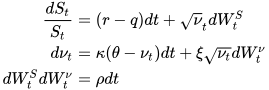

In [2]:
NUM_DAYS = 3 * 365
NUM_TIMES = 10
VOLATILITY_SPAN = 30
NUM_STRIKES = 3
BATCH_SIZE = 2

The idea is to train a model that learns to distinguish between
* real-world stock prices
* Heston-SDE paths

Each Heston-SDE path is associated with an $(r, q, \kappa, \theta, \xi, \rho)$ and therefore the model would implicitly give the likelihood of this tuple.

In [3]:
class Heston(torch.nn.Module):

    noise_type = "general"
    sde_type = "ito"
    state_size = 2
    brownian_size = 1

    def __init__(self, r=1e-2, kappa=10.0, theta=18.0, xi=.9, q=1e-3, rho=-.75):
        super().__init__()
        self.r = torch.nn.Parameter(torch.tensor(r))
        self.q = torch.nn.Parameter(torch.tensor(q))
        self.kappa = torch.nn.Parameter(torch.tensor(kappa))
        self.theta = torch.nn.Parameter(torch.tensor(theta))
        self.xi = torch.nn.Parameter(torch.tensor(xi))
        self.rho = torch.nn.Parameter(torch.tensor(rho))  # TODO

    def f(self, t, y):
        multiplicator = torch.tensor([self.r - self.q, - self.kappa])
        drift = torch.mul(multiplicator, y)
        summand = torch.tensor([0, self.kappa * self.theta])
        drift += summand
        return drift.view(y.shape[0], self.state_size)

    def g(self, t, y):
        diffusion_1 = torch.sqrt(y[:, -1])
        diffusion_2 = self.xi * torch.sqrt(y[:, -1])
        diffusion = torch.stack([diffusion_1, diffusion_2], dim=-1)
        return diffusion.view(y.shape[0], self.state_size, self.brownian_size)


In [4]:
def get_prices(ticker):
    start, end = datetime.today() - timedelta(days=NUM_DAYS), datetime.today()
    ticker_data = yf.download(ticker, start=start, end=end)
    ticker_data["Instant Volatility"] = ticker_data["Adj Close"].pct_change().ewm(span=VOLATILITY_SPAN, adjust=False).std()
    return ticker_data.iloc[100:][["Adj Close", "Instant Volatility"]].dropna()

def get_trajectories(prices):
    trajectories, volatilities = [], []
    for date, data in prices.iterrows():
        future_prices = prices.loc[[date + timedelta(days=i) for i in range(2 * NUM_TIMES) if date + timedelta(days=i) in prices.index], "Adj Close"]
        if len(future_prices) >= NUM_TIMES:
            trajectories.append(list(future_prices[:NUM_TIMES]))
            volatilities.append(data["Instant Volatility"] * 1000)
    return torch.tensor(trajectories), torch.tensor(volatilities)

In [5]:
def get_option_prices(terminal_states, strikes):
    
    strikes = strikes.unsqueeze(-1)
    terminal_states = terminal_states.unsqueeze(0)
    
    broadcast_differences = terminal_states - strikes
    mask = sigmoid(broadcast_differences)
    
    option_prices = torch.mul(broadcast_differences, mask)
    return option_prices

def get_loss_function(actual_terminal_states):
    
    min_state, max_state = torch.min(actual_terminal_states), torch.max(actual_terminal_states)
    strikes = torch.linspace(min_state, max_state, NUM_STRIKES)
    actual_option_prices = get_option_prices(actual_terminal_states, strikes)
    
    def loss_function(estimated_terminal_states):
        estimated_option_prices = get_option_prices(estimated_terminal_states, strikes)
        differences = actual_option_prices - estimated_option_prices
        return torch.norm(differences)
    
    return loss_function

In [6]:
def plot_trajectories(trajectories):
    for trajectory in trajectories[:100]:
        if torch.isnan(trajectory).any():
            color = "red"
        else:
            color = "green"
        plt.plot(trajectory.detach(), c=color, alpha=.5)
    plt.show()

In [7]:
def train_loop(num_epochs, all_trajectories, all_volatilities):

    t0, t1 = 0.0, 1.0
    ts = torch.linspace(t0, t1, NUM_TIMES)
    bm = BrownianInterval(t0=t0, t1=t1, size=(len(all_trajectories), 1))
    sde = Heston()
    sde.train()
    optimizer = torch.optim.SGD(sde.parameters(), lr=1e-4)
    
    for epoch in range(num_epochs):

        permutation = torch.randperm(len(all_trajectories))
        trajectories = all_trajectories[permutation[:BATCH_SIZE]]
        volatilities = all_volatilities[permutation[:BATCH_SIZE]]
        plot_trajectories(trajectories)

        initial_states, actual_terminal_states = trajectories[:, 0], trajectories[:, -1]
        y0 = torch.stack([initial_states, volatilities], dim=-1)
        loss_function = get_loss_function(actual_terminal_states)

        estimated_trajectories = torchsde.sdeint(sde, y0, ts, method="euler", bm=bm(t0, t1)[permutation[:BATCH_SIZE]])[..., 0].transpose(0, 1)
        estimated_terminal_states = estimated_trajectories[..., -1]
        plot_trajectories(estimated_trajectories)
        #if torch.isnan(estimated_terminal_states).any():
            #raise AssertionError

        if False:
            histogram(estimated_terminal_states.detach(), label="estimated", color="orange")
            histogram(actual_terminal_states.detach(), label="actual", color="grey")
            plt.show()
        
        loss = loss_function(estimated_terminal_states)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print(f"Epoch {epoch}: Loss = {loss.item():>.7f}")

[*********************100%***********************]  1 of 1 completed


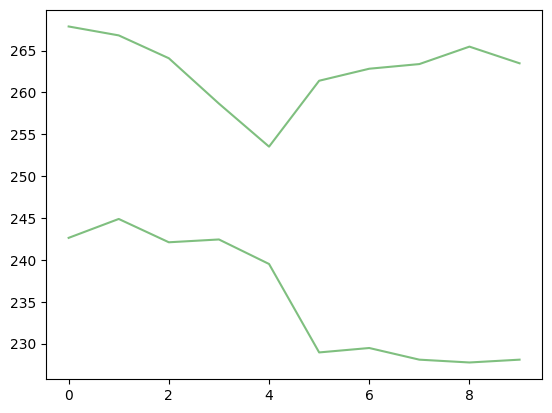

AttributeError: 'Tensor' object has no attribute 'levy_area_approximation'

In [8]:
tickers = ["ROG.SW", "NESN.SW", "NOVN.SW"]#pd.read_csv("bats_symbols.csv")["Name"]
parameter_names = ["r", "q", "theta", "xi", "kappa"]
for ticker in tickers:
    
    prices = get_prices(ticker)
    trajectories, volatilities = get_trajectories(prices)

    train_loop(10, trajectories, volatilities)
    
    break